# Dog breed classifier

### Imports

Pre-processing: Numpy, pandas, sklearn

Training: Tensorflow, keras

Visualisation: Matplotlib, seaborn 

Optimiztions: Opencv, albumentations

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
  
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
  
import cv2 
import tensorflow as tf 
from tensorflow import keras
import keras
from keras import layers
from functools import partial 
import albumentations as A

from pathlib import Path
import imagesize
from PIL import Image
import os
  
import warnings 
warnings.filterwarnings('ignore') 
AUTO = tf.data.experimental.AUTOTUNE

### Importing dat set 

This is where we can setup the labels by correlating the filepath with the id/breed. We can then import and display an image of a random dog to seen if the paths are correct and have been imported correctly.

In [3]:
df = pd.read_csv('labels.csv') 
df['filepath'] = 'train/' + df['id'] + '.jpg'
print(len(df), "Dogs" )
df.head()

10222 Dogs


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


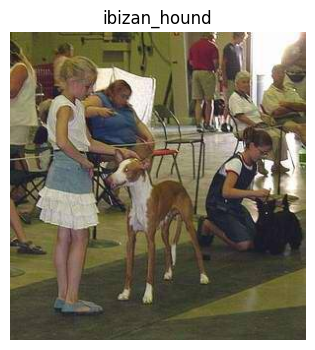

In [3]:
%matplotlib inline
plt.subplots(figsize=(4, 4)) 
k = np.random.randint(0, len(df)-1) 
img = cv2.imread(df.loc[k, 'filepath']) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) 
plt.title(df.loc[k, 'breed']) 
plt.axis('off') 
plt.show() 

Label encoding is a type of preprocessing that is needed to translate the labels into something that the model will understand. This need to be done as it needs to how off it was which cannot be done with words. Wew can also split the dataset into training and testing. This is usually done on a 4:1 ratio and can be seen below.

In [4]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed']) 

features = df['filepath'] 

target = df['breed'] 
  
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=10) 
  
X_train.shape, X_val.shape 

((8177,), (2045,))

In [5]:
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
# Get the Image Resolutions
filedimens = pd.DataFrame([])
filedimens['id'] = df["id"]
filedimens['size'] = [imagesize.get(f) for f in df['filepath']]


In [ ]:
# Convert it to Dataframe and compute aspect ratio
filedimens[["Width", "Height"]] = pd.DataFrame(filedimens["size"].tolist(), index=filedimens.index)
filedimens["Aspect Ratio"] = round(filedimens["Width"] / filedimens["Height"], 2)
filedimens.head()

,id,size,Width,Height,Aspect Ratio
0,000bec180eb18c7604dcecc8fe0dba07,"(500, 375)",500,375,1.33
1,001513dfcb2ffafc82cccf4d8bbaba97,"(500, 375)",500,375,1.33
2,001cdf01b096e06d78e9e5112d419397,"(500, 375)",500,375,1.33
3,00214f311d5d2247d5dfe4fe24b2303d,"(400, 344)",400,344,1.16
4,0021f9ceb3235effd7fcde7f7538ed62,"(500, 500)",500,500,1.00


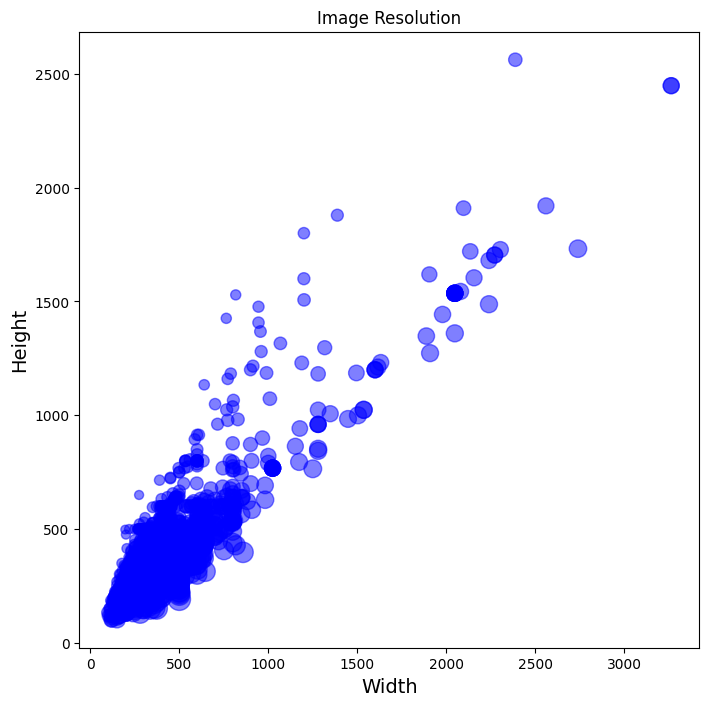

In [ ]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(filedimens.Width, filedimens.Height, color='blue', alpha=0.5, s=filedimens["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)
plt.show()

### Optimisation

Using the albumentation library we can create transformation function to augment our data so that the model doesn't overfit. Each individual transformation is performed based on the probability given. As such the model won't pick up on any inherent patterns within the transformation function.

In [69]:
transforms_train = A.Compose([ 
    A.VerticalFlip(p=0.2), 
    A.HorizontalFlip(p=0.7), 
    A.CoarseDropout(p=0.5), 
    A.RandomGamma(p=0.5), 
    A.RandomBrightnessContrast(p=1) 
]) 

The affect that the transformations can be seen below within the 6 images. These have been exaggerated to see the effect of the transformation more clearly but, as stated before, this should prevent overfitting the model.

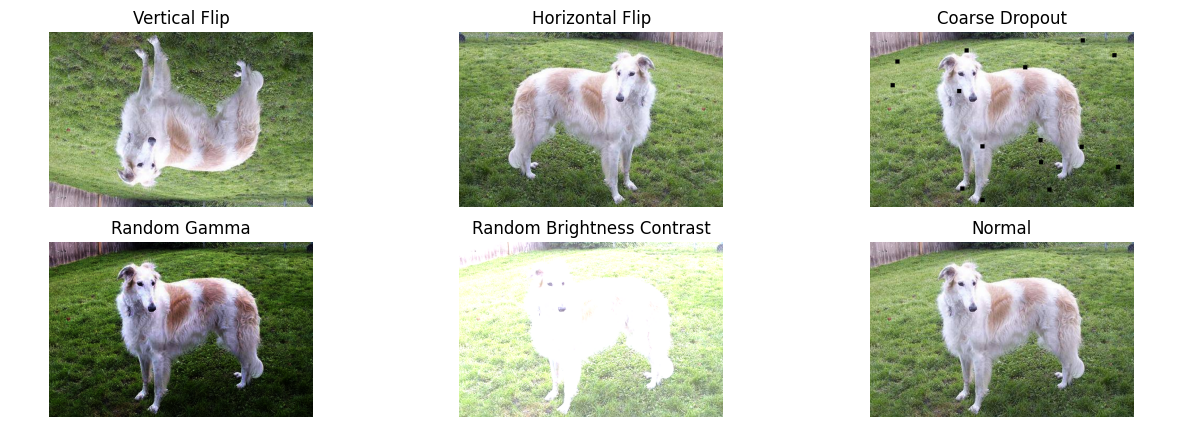

In [70]:
transformations = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),A.CoarseDropout(max_holes=20, min_holes=8, p=1),\
    A.RandomGamma(gamma_limit=[200, 500],p=1), A.RandomBrightnessContrast(brightness_limit=[0.2,0.5], contrast_limit=[0.2,0.5], p=1)]

labels = ["Vertical Flip", "Horizontal Flip", "Coarse Dropout", "Random Gamma", "Random Brightness Contrast"]

k = np.random.randint(0, len(df)-1) 
img = cv2.imread(df.loc[k, 'filepath']) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplots(figsize=(15, 5))
plt.axis('off')

for i, aug in enumerate(transformations):
    plt.subplot(2, 3, i+1)
    aug_img = aug(image=img)['image'] 
    
    plt.imshow(aug_img) 
    plt.title(labels[i]) 
    plt.axis('off')

plt.subplot(2, 3, len(transformations)+1)
plt.imshow(img) 
plt.title("Normal") 
plt.axis('off')
plt.show() 

Here are some functions that are needed for the pipeline (before entering the model)

Process data: Implements the image augmentation

Decode image: Resizing the image to 128x128 and converts the label into a one-hot vector

*One-hot vector is a 1d vector used to encode the classes without any ordinal relationship

In [71]:
def aug_fn(img): 
    aug_data = transforms_train(image=img) 
    aug_img = aug_data['image'] 
  
    return aug_img 
  
  
@tf.function 
def process_data(img, label): 
    aug_img = tf.numpy_function(aug_fn, 
                                [img], 
                                Tout=tf.float32) 
  
    return img, label 
  
  
def decode_image(filepath, label=None): 
  
    img = tf.io.read_file(filepath) 
    img = tf.image.decode_jpeg(img) 
    img = tf.image.resize(img, [200, 200]) 
    img = tf.cast(img, tf.float32) / 255.0
  
    if label == None: 
        return img 
  
    return img, tf.one_hot(indices=label, 
                           depth=120, 
                           dtype=tf.float32) 

Setting up the training and valdation dataset but it should be noted that the transformation function won't be used on the validation set.

In [72]:
train_ds = ( 
	tf.data.Dataset 
	.from_tensor_slices((X_train, Y_train)) 
	.map(decode_image, num_parallel_calls=AUTO) 
	.map(partial(process_data), num_parallel_calls=AUTO) 
	.batch(32) 
	.prefetch(AUTO) 
) 

val_ds = ( 
	tf.data.Dataset 
	.from_tensor_slices((X_val, Y_val)) 
	.map(decode_image, num_parallel_calls=AUTO) 
	.batch(32) 
	.prefetch(AUTO) 
) 

## Transfer learning 

Importing the Inception ResNet V2 we can use the the features that this model can identify in addition to the one we are about to create to help the learning process. This displayModel has already been trained on a vast dataset and therefore doesn't need to be altered. Therefore we can turn off the training for all the layers inside and creating addition layers to append to the end of this model to finally classify our images.

In [35]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

pre_trained_model = InceptionResNetV2( 
    input_shape=(200, 200, 3), 
    weights='imagenet', 
    include_top=False
) 

In [73]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('conv_7b_ac') 
print('last layer output shape: ', last_layer.output_shape) 
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 1536)


In [74]:
# Model Architecture 
x = layers.Flatten()(last_output) 
x = layers.Dense(256, activation='relu')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.35)(x) 
x = layers.BatchNormalization()(x) 
output = layers.Dense(120, activation='softmax')(x) 


model = keras.Model(pre_trained_model.input, output) 

# Model Compilation 
model.compile( 
	optimizer='adam', 
	loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
	metrics=['AUC'] 
) 

In [40]:
try:
    visualkeras.layered_view(model, type_ignore=["Dropout", "Flatten", "Dense"]).show()
except: pass

In [45]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

class myCallback(tf.keras.callbacks.Callback): 
	def on_epoch_end(self, epoch, logs={}): 
		if logs.get('val_auc') > 0.99: 
			print('\n Validation accuracy has reached upto 90%\ so, stopping further training.') 
			self.model.stop_training = True

es = EarlyStopping(patience=3, 
				monitor='val_auc', 
				restore_best_weights=True) 

lr = ReduceLROnPlateau(monitor='val_loss', 
					patience=2, 
					factor=0.5, 
					verbose=1) 


In [46]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=10, 
                    verbose=1, 
                    callbacks=[es, lr, myCallback()]) 

Epoch 1/10
256/256 [==============================] - 971s 4s/step - loss: 1.5183 - auc: 0.9639 - val_loss: 0.8476 - val_auc: 0.9790 - lr: 0.0010
Epoch 2/10
256/256 [==============================] - 1077s 4s/step - loss: 0.7506 - auc: 0.9898 - val_loss: 0.7740 - val_auc: 0.9822 - lr: 0.0010
Epoch 3/10
256/256 [==============================] - 978s 4s/step - loss: 0.5389 - auc: 0.9948 - val_loss: 0.8365 - val_auc: 0.9793 - lr: 0.0010
Epoch 4/10
256/256 [==============================] - ETA: 0s - loss: 0.4073 - auc: 0.9972
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
256/256 [==============================] - 895s 3s/step - loss: 0.4073 - auc: 0.9972 - val_loss: 0.8676 - val_auc: 0.9779 - lr: 0.0010
Epoch 5/10
256/256 [==============================] - 893s 3s/step - loss: 0.2429 - auc: 0.9990 - val_loss: 0.7955 - val_auc: 0.9784 - lr: 5.0000e-04


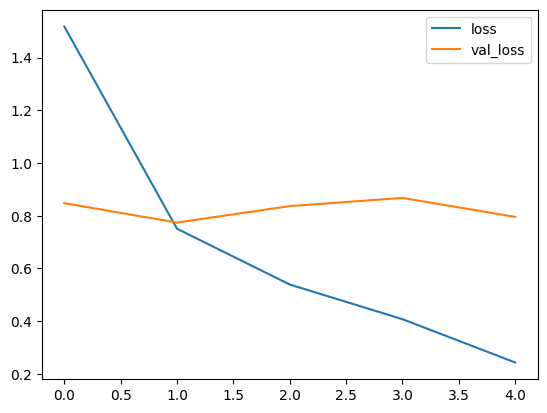

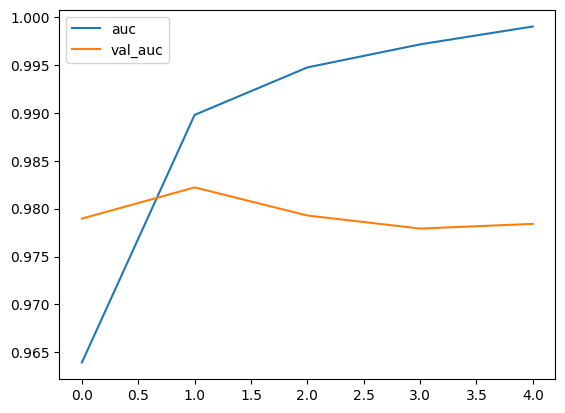

In [47]:
history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['auc', 'val_auc']].plot() 
plt.show() 

In [48]:

model_version = max([int(i) for i in os.listdir("models")] + [0]) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets


In [4]:
model_version = max([int(i) for i in os.listdir("models")] + [0])
saved_model = tf.keras.models.load_model(f'models/{model_version}')

In [28]:
saved_model = model

In [80]:
def predict(filepath, model):
    image, *_ = decode_image(imgpath,label)
    image = np.expand_dims(image, axis=0)
    print(image.shape)
    return model.predict(image, verbose=0)[0]


(1, 200, 200, 3)


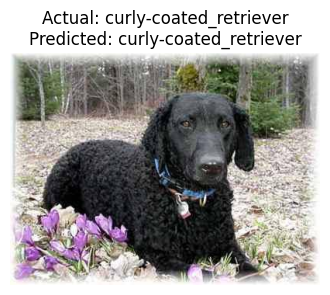

In [81]:
plt.subplots(figsize=(4, 4)) 
plt.axis('off') 
k = np.random.randint(0, len(df)-1) 

imgpath = df.loc[k, 'filepath']
label = df.loc[k, 'breed']

   
img = cv2.imread(imgpath, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) 

plt.title("Actual: " + str(le.inverse_transform([label])[0]) + "\nPredicted: "+ str(le.inverse_transform([np.argmax(predict(imgpath, saved_model))])[0]))

plt.show()

In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model(f"models/{model_version}")

In [6]:
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [30]:
id = [i for i in range(120)]
labels = le.inverse_transform(id)

labels = pd.DataFrame(labels)
labels.to_csv('labels.csv')

labels.head()

,0
0,affenpinscher
1,afghan_hound
2,african_hunting_dog
3,airedale
4,american_staffordshire_terrier


In [32]:
breed = labels.iloc[19,0]
print(breed)

boston_bull
